<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/SkimLit_models_0_to_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimlit: Model to classify sections of medical papers' abstracts.

This notebook is based on this Udemy course: https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/26316968#questions.

Model below replicates the paper available here: https://arxiv.org/abs/1612.05251 , built on the dataset available here: https://arxiv.org/abs/1710.06071.

Thank You for contributions!

### Content:

1. Get the data
2. Inspect the data
3. Prepare the data / create preprocessing pipeline
4. Create baseline model



In [ ]:
# Confirm the access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60c29d51-1068-0087-e7e9-1adea0ee3043)


## Get the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.78 MiB/s, done.


In [ ]:
# Setup data dir
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [ ]:
# Create filenames
import os
filepaths = [data_dir + '/'+ filename for filename in os.listdir(data_dir)]

In [ ]:
filepaths

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Inspect the data

### Create a helper function

In [ ]:
def get_lines(filename):
  '''
  Reads text using filename and return lines of a text as a list.
  Args:
    filename: (str) containd filepath
  Returns:
    A list of strings.
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filepaths[0])

### Check loaded data

In [ ]:
train_lines[:17]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
len(train_lines)

35135

**The data is labeled but it isn't split to target / text pairs. We have to invent a way to parse and order it appropriatelly.**

## Prepare the data

Since we are looking for the a meaning of each sentence we can skip abstract signature lines like `'###24293578\n'` and additional spacing lines `'\n'`

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def split_lines(lines):
  train_data = []
  train_data_with_nrows = []
  last_counter = 0
  counter = 0
  for i, row in enumerate(lines):
    if row[:3] != '\n':
      if row[:3] != '###':
        target, text = row.split('\t')[0], row.split('\t')[1].strip('\n')
        train_data.append([counter, target, text])
        counter+=1
      else:
        abstract_symbol = row.strip('\n')
        if i != 0:
          counter=0
    else:
      for el in train_data[-counter:]:
        train_data_with_nrows.append(el + [counter-1] + [abstract_symbol])
  return train_data_with_nrows

In [ ]:
%%time
train_data = split_lines(get_lines(filepaths[0]))
test_data = split_lines(get_lines(filepaths[1]))
val_data = split_lines(get_lines(filepaths[2]))

CPU times: user 711 ms, sys: 83.6 ms, total: 795 ms
Wall time: 792 ms


### Create DataFrames for train, test and validation data

In [ ]:
train_data_df = pd.DataFrame(train_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
train_data_df.head(20), len(train_data_df)

(    row       target                                               text  \
 0     0   BACKGROUND  This study analyzed liver function abnormaliti...   
 1     1      RESULTS  A post hoc analysis was conducted with the use...   
 2     2      RESULTS  Liver function tests ( LFTs ) were measured at...   
 3     3      RESULTS  Survival analyses were used to assess the asso...   
 4     4      RESULTS  The percentage of patients with abnormal LFTs ...   
 5     5      RESULTS  When mean hemodynamic profiles were compared i...   
 6     6      RESULTS  Multivariable analyses revealed that patients ...   
 7     7  CONCLUSIONS  Abnormal LFTs are common in the ADHF populatio...   
 8     8  CONCLUSIONS  Elevated MELD-XI scores are associated with po...   
 9     0   BACKGROUND  Minimally invasive endovascular aneurysm repai...   
 10    1   BACKGROUND  The aim of this study was to analyse the cost-...   
 11    2      METHODS  Resource use was determined from the Amsterdam...   
 12    3    

In [ ]:
test_data_df = pd.DataFrame(test_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
test_data_df.head(20), len(test_data_df)

(    row       target                                               text  \
 0     0   BACKGROUND  IgE sensitization to Aspergillus fumigatus and...   
 1     1   BACKGROUND  It is not clear whether these patients would b...   
 2     2    OBJECTIVE  We sought to determine whether a @-month cours...   
 3     3      METHODS  Asthmatic patients who were IgE sensitized to ...   
 4     4      METHODS  Primary outcomes were improvement in quality o...   
 5     5      RESULTS              Sixty-five patients were randomized .   
 6     6      RESULTS  Fifty-nine patients started treatment ( @ rece...   
 7     7      RESULTS  Fifty-six patients took the full @ months of m...   
 8     8      RESULTS  Between the voriconazole and placebo groups , ...   
 9     9  CONCLUSIONS  We were unable to show a beneficial effect of ...   
 10    0   BACKGROUND  Opioid antagonists ( e.g. , naltrexone ) and p...   
 11    1   BACKGROUND  The use of higher doses to achieve greater eff...   
 12    2   B

In [ ]:
val_data_df = pd.DataFrame(val_data, columns = ['row', 'target', 'text', 'nrows', 'abstract'])
val_data_df.head(20), len(val_data_df)

(    row       target                                               text  \
 0     0    OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
 1     1      METHODS  A total of @ patients with primary knee OA wer...   
 2     2      METHODS  Outcome measures included pain reduction and i...   
 3     3      METHODS  Pain was assessed using the visual analog pain...   
 4     4      METHODS  Secondary outcome measures included the Wester...   
 5     5      METHODS  Serum levels of interleukin @ ( IL-@ ) , IL-@ ...   
 6     6      RESULTS  There was a clinically relevant reduction in t...   
 7     7      RESULTS  The mean difference between treatment arms ( @...   
 8     8      RESULTS  Further , there was a clinically relevant redu...   
 9     9      RESULTS  These differences remained significant at @ we...   
 10   10      RESULTS  The Outcome Measures in Rheumatology Clinical ...   
 11   11  CONCLUSIONS  Low-dose oral prednisolone had both a short-te...   
 12    0   B

In [ ]:
list_of_datasets = [train_data_df, test_data_df, val_data_df]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Inspect the data a bit more

#### Chceck the distribution, mean and percentiles of sentence length

In [ ]:
train_data_len_sentences = [len(words) for words in train_data_df.text.str.split(" ")]
test_data_len_sentences = [len(words) for words in test_data_df.text.str.split(" ")]
val_data_len_sentences = [len(words) for words in val_data_df.text.str.split(" ")]

In [ ]:
train_data_len_sentences_mean = np.mean(train_data_len_sentences)
test_data_len_sentences_mean = np.mean(test_data_len_sentences)
val_data_len_sentences_mean = np.mean(val_data_len_sentences)

In [ ]:
train_data_len_sentences_mean, test_data_len_sentences_mean, val_data_len_sentences_mean

(26.178463580554173, 26.42244803389382, 26.338269273494777)

In [ ]:
len_sentences = [train_data_len_sentences, test_data_len_sentences, val_data_len_sentences]

In [ ]:
len(np.unique(len_sentences[0]))

146

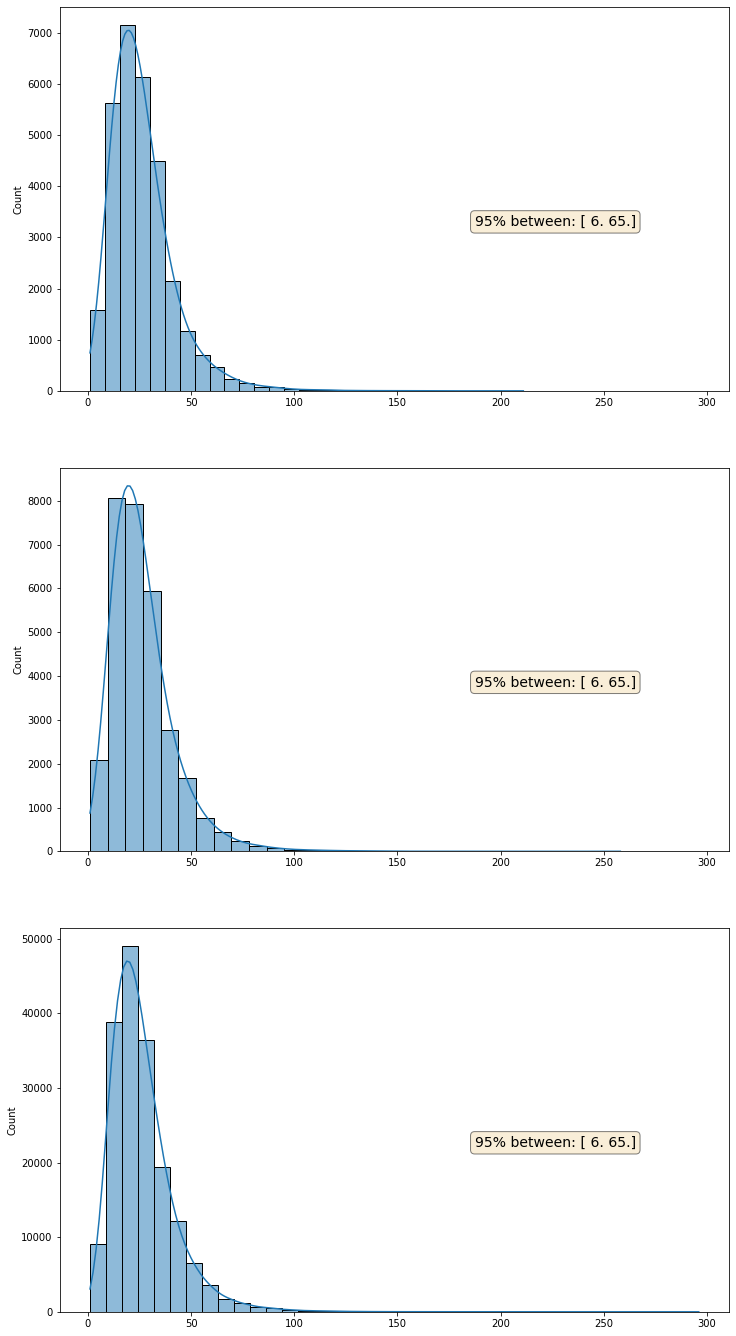

In [ ]:

fig = plt.figure(figsize=(12, 24))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, sharex=ax1)
ax3 = plt.subplot(313, sharex=ax1)
axes = [ax1, ax2, ax3]
for it, dataset in enumerate(len_sentences):
  sns.histplot(dataset, bins=int(len(np.unique(len_sentences[it]))/5), ax=axes[it], kde=True, kde_kws={'bw_adjust':2.2} )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axes[it].text(0.05, 0.95, f'95% between: {np.quantile(len_sentences[it], [0.025, 0.975])}', transform=axes[it].transAxes, fontsize=14, position=(0.62,0.43), bbox=props)
plt.show()

In [ ]:
predicted_len_sentences = [train_data_len_sentences_mean, test_data_len_sentences_mean, val_data_len_sentences_mean]

#### Check the distribution of labels and visualize general data about each dataset

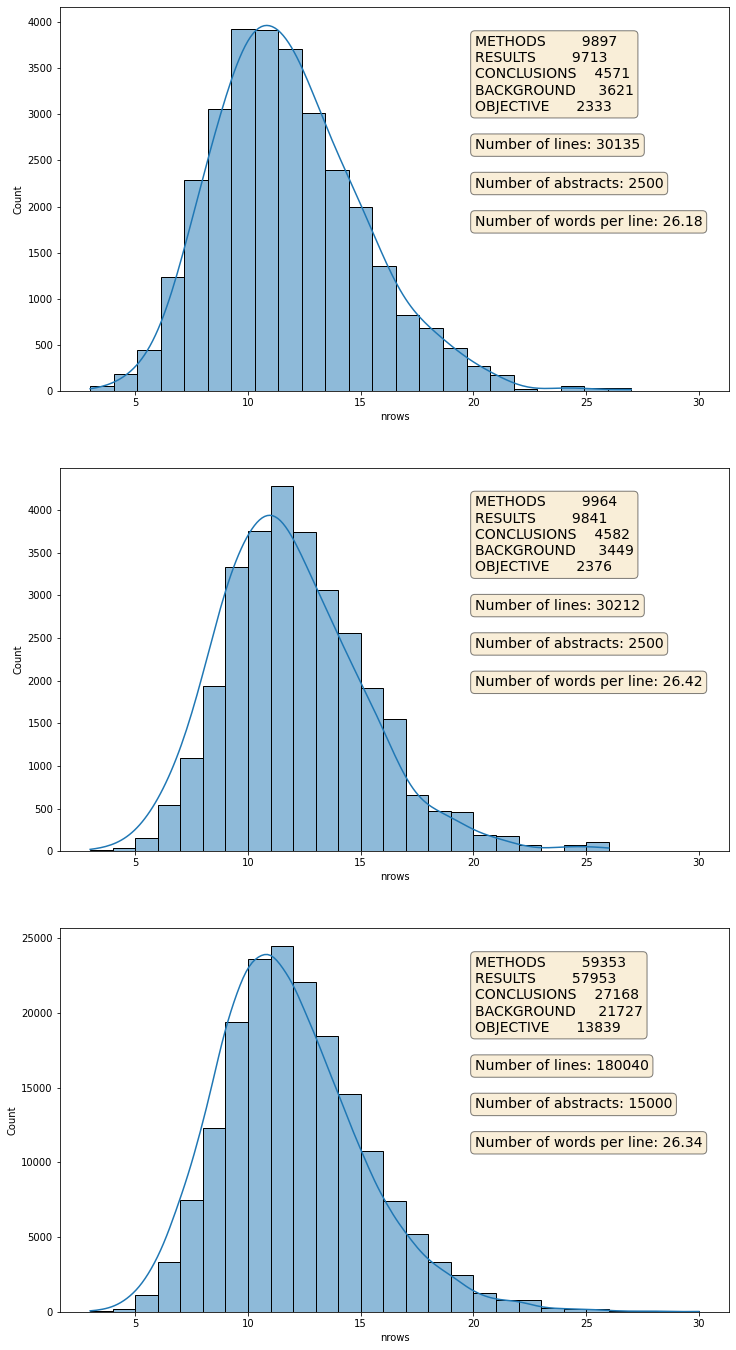

In [ ]:

fig = plt.figure(figsize=(12, 24))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312, sharex=ax1)
ax3 = plt.subplot(313, sharex=ax1)
axes = [ax1, ax2, ax3]
for it, dataset in enumerate(list_of_datasets):
  sns.histplot(dataset.nrows, bins=dataset.nrows.nunique(), ax=axes[it], kde=True, kde_kws={'bw_adjust':2.2} )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axes[it].text(0.05, 0.95, dataset.target.value_counts().to_string(), transform=axes[it].transAxes, fontsize=14, position=(0.62,0.73), bbox=props)
  axes[it].text(0.05, 0.95, f'Number of lines: {len(dataset)}', transform=axes[it].transAxes, fontsize=14, position=(0.62,0.63), bbox=props)
  axes[it].text(0.05, 0.95, f'Number of abstracts: {dataset.abstract.nunique()}', transform=axes[it].transAxes, fontsize=14, position=(0.62,0.53), bbox=props)
  axes[it].text(0.05, 0.95, f'Number of words per line: {predicted_len_sentences[it]:.2f}', transform=axes[it].transAxes, fontsize=14, position=(0.62,0.43), bbox=props)
plt.show()

### Create lists of strings for feature vectors

In [ ]:
# Create lists with txt data:
train_txt = train_data_df.text.str.lower().to_list()
test_txt = test_data_df.text.str.lower().to_list()
val_txt = val_data_df.text.str.lower().to_list()

len(train_txt), len(test_txt), len(val_txt)

(30135, 30212, 180040)

In [ ]:
train_txt[:7]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

### Create one-hot labels


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
# Instantiate the encoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
train_labels_onehot = one_hot_encoder.fit_transform(train_data_df.target.to_numpy().reshape(-1,1))

In [ ]:
train_labels_onehot.shape[1] == train_data_df.target.nunique(), train_labels_onehot.shape[0] == len(train_data_df.target)

(True, True)

In [ ]:
test_labels_onehot = one_hot_encoder.transform(test_data_df.target.to_numpy().reshape(-1,1))
val_labels_onehot  = one_hot_encoder.transform(val_data_df.target.to_numpy().reshape(-1,1))

In [ ]:
test_labels_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
one_hot_encoder.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_BACKGROUND', 'x0_CONCLUSIONS', 'x0_METHODS', 'x0_OBJECTIVE',
       'x0_RESULTS'], dtype=object)

### Create numeric labels
Which will be used for Multinomial Naive Bayes baseline model (model_0)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
train_labels_encoded = label_encoder.fit_transform(train_data_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_data_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_data_df.target.to_numpy())

In [ ]:
len(train_labels_encoded) == len(train_data_df.target)

True

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Create text vectorization layer

In [ ]:
# Import modules
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

In [ ]:
# Instantiate TextVectorization layer
text_vectorization = TextVectorization(
    max_tokens = 10000,
    standardize = 'lower_and_strip_punctuation',
    split='whitespace',
    ngrams=3,
    output_mode='int',
    output_sequence_length=27,
    pad_to_max_tokens=True,
)

In [ ]:
# Adapt the vectorizer to train_data
text_vectorization.adapt(train_txt)

In [ ]:
text_vectorization([train_data_df.text[0]])

<tf.Tensor: shape=(1, 27), dtype=int64, numpy=
array([[  25,   18,  641, 1233,  196, 5280,    5,  305,  432,   12, 2907,
           7,  493,  288,    1,  305,  432,    1,   88,    1,    1,    1,
           1,    1, 5430,  969,    1]])>

In [ ]:
# Check tokenization with TextVectorizer vocabulary
for token in text_vectorization([train_data_df.text[0]])[0].numpy():
  print(f'Token: {token}, word: {text_vectorization.get_vocabulary()[token]}')

Token: 25, word: this
Token: 18, word: study
Token: 641, word: analyzed
Token: 1233, word: liver
Token: 196, word: function
Token: 5280, word: abnormalities
Token: 5, word: in
Token: 305, word: heart
Token: 432, word: failure
Token: 12, word: patients
Token: 2907, word: admitted
Token: 7, word: with
Token: 493, word: severe
Token: 288, word: acute
Token: 1, word: [UNK]
Token: 305, word: heart
Token: 432, word: failure
Token: 1, word: [UNK]
Token: 88, word: this study
Token: 1, word: [UNK]
Token: 1, word: [UNK]
Token: 1, word: [UNK]
Token: 1, word: [UNK]
Token: 1, word: [UNK]
Token: 5430, word: in heart
Token: 969, word: heart failure
Token: 1, word: [UNK]


### Prepare data pipelines

In [ ]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_txt, train_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_txt, test_labels_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_txt, val_labels_onehot))

In [ ]:
# Batch the datasets and turn them to prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

**Since our datasets reflect the order of sentences in each abstract we will not shuffle the data.**

## Create baseline model: model_0
This is going to be Naive Bayes model wir TF-IDF encoder.

In [ ]:
# Download necessary modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# Create model as a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

In [ ]:
model_0.fit(train_txt, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(test_txt, test_labels_encoded)

0.6760889712696941

In [ ]:
model_0_preds = model_0.predict(test_txt)

In [ ]:
model_0_crp = classification_report(test_labels_encoded, model_0_preds, output_dict=True)
model_0_crp_df = pd.DataFrame(model_0_crp).transpose()

In [ ]:
{f'{k}': f'{v}' for k, v in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

{'BACKGROUND': '0',
 'CONCLUSIONS': '1',
 'METHODS': '2',
 'OBJECTIVE': '3',
 'RESULTS': '4'}

In [ ]:
# My own plot the curves function
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves_eval(history, eval_acc=0.5, eval_loss=0.5):

    '''
    Uses seaborn and to plot curves
    as scatterplot with regression
    attrs:
    history: tf history object
    eval_acc: (float) evaluation accuracy
    eval_loss: (float) evaluation loss
    '''

    # Create DataFrame
    df = pd.DataFrame(history.history)
    df.head()
    # Setup the figure
    plt.figure(figsize=(32, 8))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')

    # Plot loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x='index', y='loss', data=df.reset_index(),
                label='Training Loss')
    sns.lineplot(x='index', y='val_loss', data=df.reset_index(),
                label='Validation Loss')
    plt.axhline(y=eval_loss, label='Evaluation Loss', color='black', linestyle=':')
    plt.legend()
    plt.title('Loss Curves')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x='index', y='accuracy', data=df.reset_index(),
                label='Training Accuracy')
    sns.lineplot(x='index', y='val_accuracy', data=df.reset_index(),
                label='Validation Accuracy')
    plt.axhline(y=eval_acc, label='Evaluation Accuracy', color='black', linestyle=':')
    plt.legend()
    plt.title('Accuracy Curves')

In [ ]:
# My own classification report function
def create_crp(classification_report, class_names=None, experiment_name='Experiment'):

  '''
  Creates pandas DataFrame from sklearn classification_report
  attrs:
  classification_report: (dict)
  class_names: (arr of str) list of class names
  experiment_name: (str) a name that will be added
    as an upper level of the column axis multiindex
  '''
  # Create DataFrame
  df = pd.DataFrame(classification_report).transpose()
  df.rename(index={f'{k}': f'{k}_{v.lower()}' for k, v in zip(range(len(class_names)), class_names )}, inplace=True)

  return pd.concat({f'{experiment_name}': df}, axis=1)


In [ ]:
create_crp(model_0_crp, label_encoder.classes_, experiment_name='Model 0: Baseline')

Model 0: Baseline                                  
                      precision    recall  f1-score       support
0_background           0.672229  0.327051  0.440023   3449.000000
1_conclusions          0.613714  0.468791  0.531552   4582.000000
2_methods              0.658836  0.866921  0.748689   9964.000000
3_objective            0.704225  0.021044  0.040866   2376.000000
4_results              0.713972  0.859872  0.780159   9841.000000
accuracy               0.676089  0.676089  0.676089      0.676089
macro avg              0.672595  0.508736  0.508258  30212.000000
weighted avg           0.675051  0.676089  0.635105  30212.000000

In [ ]:
type(label_encoder.classes_)

numpy.ndarray

## Model 1: 1D CNN

In [ ]:
# Import layer classes
from tensorflow.keras.layers import Conv1D, Input, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D

In [ ]:
# Create an embedding layer for model_1
embedding_1 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Create model_1 using functional API
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1(x)
x = Conv1D(filters=16, kernel_size=5, strides=1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')

In [ ]:
model_1.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 23, 16)            10256     
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)              

In [ ]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
tf.convert_to_tensor(train_txt, dtype=tf.string)

<tf.Tensor: shape=(30135,), dtype=string, numpy=
array([b'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
       b'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
       b'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
       ...,
       b'there was no significant association between satisfaction and treatment groups at week @ .',
       b'no adverse effects were reported .',
       b'performing a @-week do-as-tolerated program of eccentric heel-drop exercises , compared to the recommended @ repetitions per day , did not lead to lesser improvement for individuals with midportion achilles tendinopathy , based on visa-a and vas scores .'],
      dtype=object)>

In [ ]:
history_1 = model_1.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)

)

Epoch 1/50
942/942 [==============================] - 29s 21ms/step - loss: 1.4783 - accuracy: 0.3596 - val_loss: 1.4524 - val_accuracy: 0.3748
Epoch 2/50
942/942 [==============================] - 20s 21ms/step - loss: 1.4338 - accuracy: 0.4282 - val_loss: 1.4092 - val_accuracy: 0.4192
Epoch 3/50
942/942 [==============================] - 20s 22ms/step - loss: 1.3660 - accuracy: 0.4482 - val_loss: 1.3181 - val_accuracy: 0.4594
Epoch 4/50
942/942 [==============================] - 20s 21ms/step - loss: 1.2674 - accuracy: 0.4612 - val_loss: 1.2185 - val_accuracy: 0.4717
Epoch 5/50
942/942 [==============================] - 20s 21ms/step - loss: 1.1745 - accuracy: 0.5072 - val_loss: 1.1407 - val_accuracy: 0.5318
Epoch 6/50
942/942 [==============================] - 20s 21ms/step - loss: 1.1152 - accuracy: 0.5493 - val_loss: 1.0944 - val_accuracy: 0.5568
Epoch 7/50
942/942 [==============================] - 20s 21ms/step - loss: 1.0695 - accuracy: 0.5732 - val_loss: 1.0509 - val_accuracy:

In [ ]:
# Evaluate on test data
model_1_eval = model_1.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.5834 - accuracy: 0.7837


### Chuju jebany przestrań wyłączać środowisko

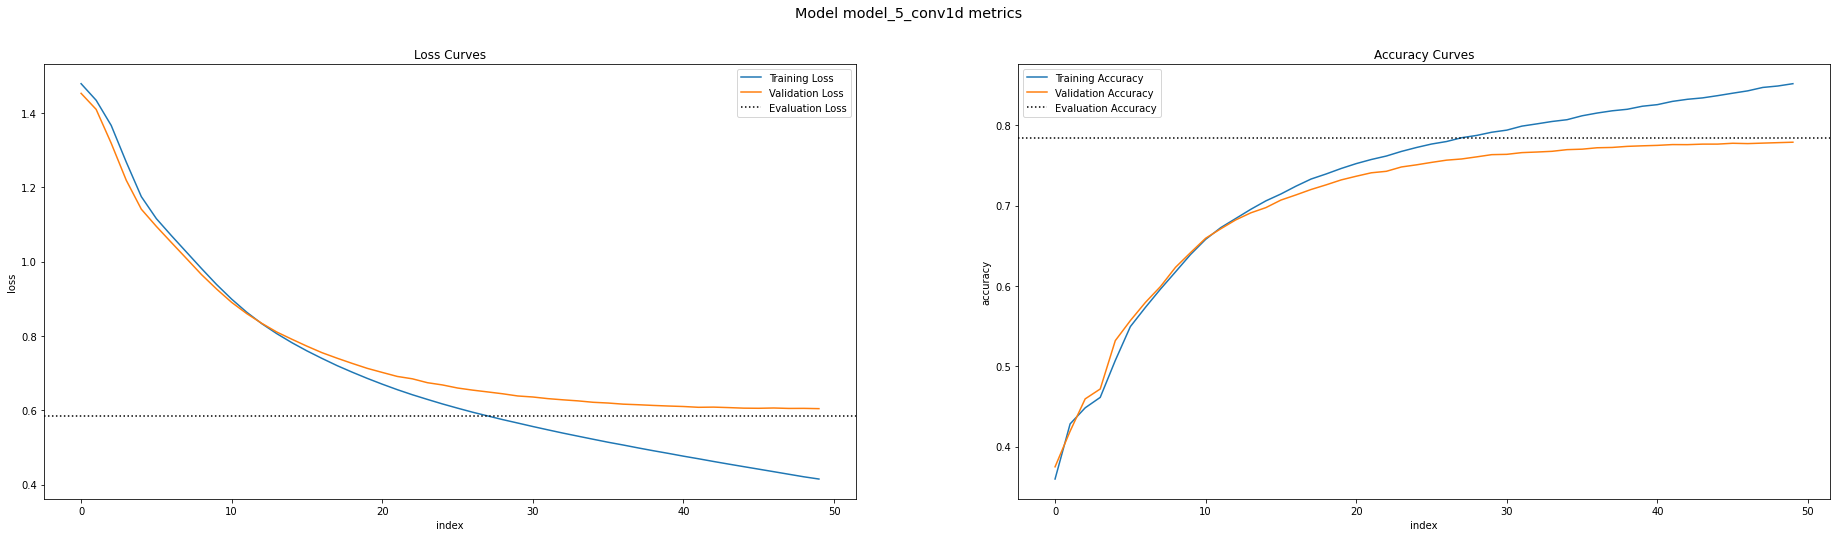

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1, eval_loss=model_1_eval[0], eval_acc=model_1_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_preds = tf.argmax(model_1.predict(test_txt), axis=1)

945/945 [==============================] - 2s 3ms/step


In [ ]:
# Create a classification report as dict
model_1_crp = classification_report(test_labels_encoded, model_1_preds, output_dict=True)

In [ ]:
model_1_crp_df = create_crp(model_1_crp, label_encoder.classes_, experiment_name='Model 1: Conv1D 16 filters')
model_1_crp_df

Model 1: Conv1D 16 filters                                  
                               precision    recall  f1-score       support
0_background                    0.599219  0.622499  0.610637   3449.000000
1_conclusions                   0.671603  0.682890  0.677199   4582.000000
2_methods                       0.839674  0.899338  0.868482   9964.000000
3_objective                     0.708755  0.500842  0.586930   2376.000000
4_results                       0.857574  0.838228  0.847790   9841.000000
accuracy                        0.783662  0.783662  0.783662      0.783662
macro avg                       0.735365  0.708759  0.718208  30212.000000
weighted avg                    0.782268  0.783662  0.781154  30212.000000

### Amend the model

#### Adding Dropout

In [ ]:
# Import more layers
from tensorflow.keras.layers import Dropout

In [ ]:
# Create an embedding layer for model_1_1
embedding_1_1 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Create conv1d model with additional Dropout layer
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1_1(x)
x = Conv1D(filters=16, kernel_size=5, strides=1)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1_1 = tf.keras.Model(inputs, outputs, name='model_1_1_conv1d')

In [ ]:
model_1_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_1_1.summary()

Model: "model_1_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 27, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 16)            10256     
                                                                 
 dropout (Dropout)           (None, 23, 16)            0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                 

In [ ]:
history_1_1 = model_1_1.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)
)

Epoch 1/50
942/942 [==============================] - 20s 21ms/step - loss: 1.4806 - accuracy: 0.3713 - val_loss: 1.4533 - val_accuracy: 0.4397
Epoch 2/50
942/942 [==============================] - 22s 23ms/step - loss: 1.4023 - accuracy: 0.4404 - val_loss: 1.3908 - val_accuracy: 0.4582
Epoch 3/50
942/942 [==============================] - 20s 21ms/step - loss: 1.2885 - accuracy: 0.4673 - val_loss: 1.2682 - val_accuracy: 0.4790
Epoch 4/50
942/942 [==============================] - 20s 21ms/step - loss: 1.1615 - accuracy: 0.5248 - val_loss: 1.1686 - val_accuracy: 0.5328
Epoch 5/50
942/942 [==============================] - 20s 21ms/step - loss: 1.0686 - accuracy: 0.5867 - val_loss: 1.0985 - val_accuracy: 0.5836
Epoch 6/50
942/942 [==============================] - 20s 21ms/step - loss: 0.9927 - accuracy: 0.6196 - val_loss: 1.0401 - val_accuracy: 0.6206
Epoch 7/50
942/942 [==============================] - 20s 22ms/step - loss: 0.9288 - accuracy: 0.6440 - val_loss: 0.9921 - val_accuracy:

In [ ]:
# Evaluate on test data
model_1_1_eval = model_1_1.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.6468 - accuracy: 0.7679


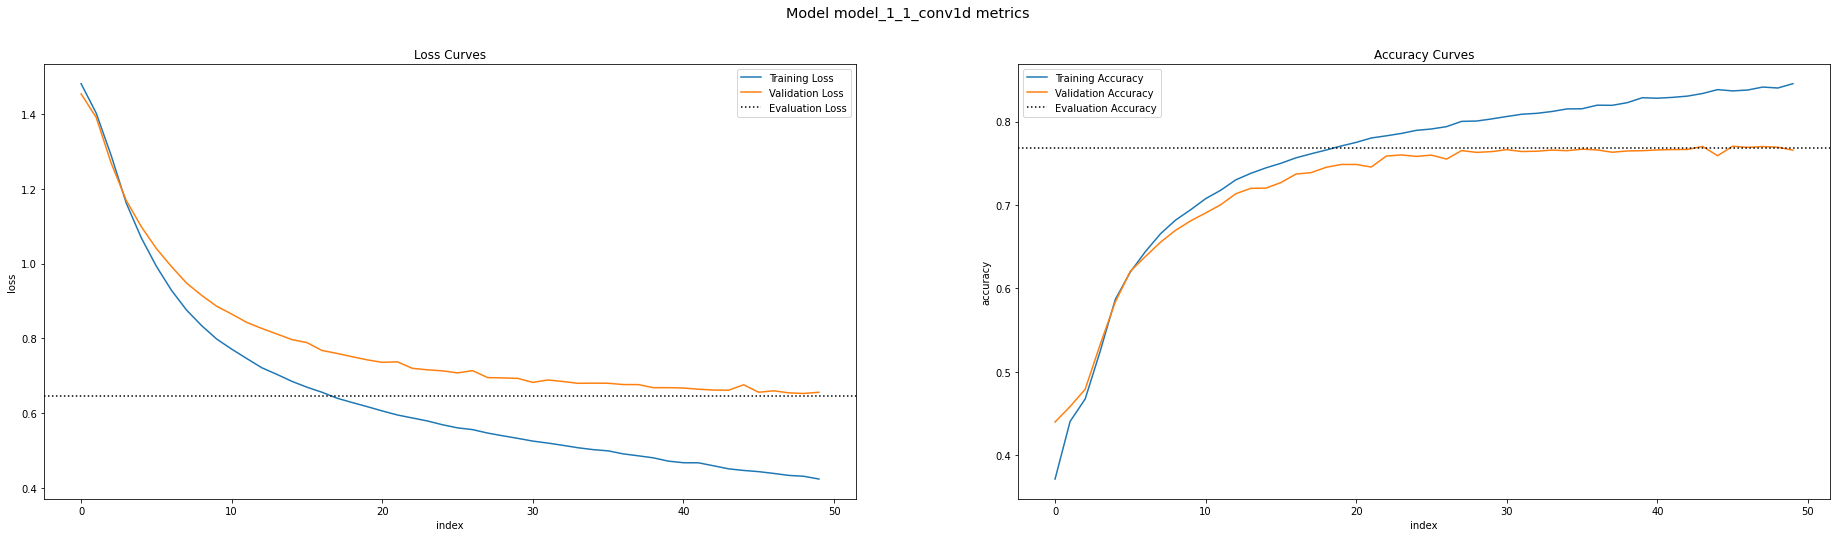

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1_1, eval_loss=model_1_1_eval[0], eval_acc=model_1_1_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_1_preds = tf.argmax(model_1_1.predict(test_txt), axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
# Create a classification report as dict
model_1_1_crp = classification_report(test_labels_encoded, model_1_1_preds, output_dict=True)

In [ ]:
model_1_1_crp_df = create_crp(model_1_1_crp, label_encoder.classes_, experiment_name='Model 1_1: Conv1D 16 filters Dropout .5')
model_1_1_crp_df

Model 1_1: Conv1D 16 filters Dropout .5                      \
                                            precision    recall  f1-score   
0_background                                 0.486077  0.809800  0.607504   
1_conclusions                                0.739491  0.583588  0.652354   
2_methods                                    0.850614  0.876054  0.863146   
3_objective                                  0.886040  0.261785  0.404159   
4_results                                    0.847765  0.851641  0.849698   
accuracy                                     0.767874  0.767874  0.767874   
macro avg                                    0.761997  0.676573  0.675372   
weighted avg                                 0.794003  0.767874  0.761516   

                             
                    support  
0_background    3449.000000  
1_conclusions   4582.000000  
2_methods       9964.000000  
3_objective     2376.000000  
4_results       9841.000000  
accuracy           0.767874  
macro avg      30212.000000  
weighted avg   30212.000000

#### Longer Convolution

In [ ]:
# Create an embedding layer for model_1_1
embedding_1_2 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Create conv1d model with additional Dropout layer
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1_2(x)
x = Conv1D(filters=32, kernel_size=5, strides=1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1_2 = tf.keras.Model(inputs, outputs, name='model_1_1_conv1d')

In [ ]:
model_1_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_1_2.summary()

Model: "model_1_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 27, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 32)            20512     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 5)            

In [ ]:
history_1_2 = model_1_2.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)
)

Epoch 1/50
942/942 [==============================] - 20s 21ms/step - loss: 1.4766 - accuracy: 0.3723 - val_loss: 1.4517 - val_accuracy: 0.4180
Epoch 2/50
942/942 [==============================] - 19s 21ms/step - loss: 1.4375 - accuracy: 0.4329 - val_loss: 1.4184 - val_accuracy: 0.4395
Epoch 3/50
942/942 [==============================] - 19s 20ms/step - loss: 1.3807 - accuracy: 0.4578 - val_loss: 1.3294 - val_accuracy: 0.4609
Epoch 4/50
942/942 [==============================] - 19s 21ms/step - loss: 1.2601 - accuracy: 0.4658 - val_loss: 1.1985 - val_accuracy: 0.4691
Epoch 5/50
942/942 [==============================] - 19s 21ms/step - loss: 1.1515 - accuracy: 0.5142 - val_loss: 1.1177 - val_accuracy: 0.5412
Epoch 6/50
942/942 [==============================] - 19s 21ms/step - loss: 1.0891 - accuracy: 0.5600 - val_loss: 1.0696 - val_accuracy: 0.5651
Epoch 7/50
942/942 [==============================] - 19s 21ms/step - loss: 1.0425 - accuracy: 0.5857 - val_loss: 1.0257 - val_accuracy:

# Za długo :([tekst linku](https:// [tekst linku](https://))

In [ ]:
# Evaluate on test data
model_1_2_eval = model_1_2.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.5777 - accuracy: 0.7840


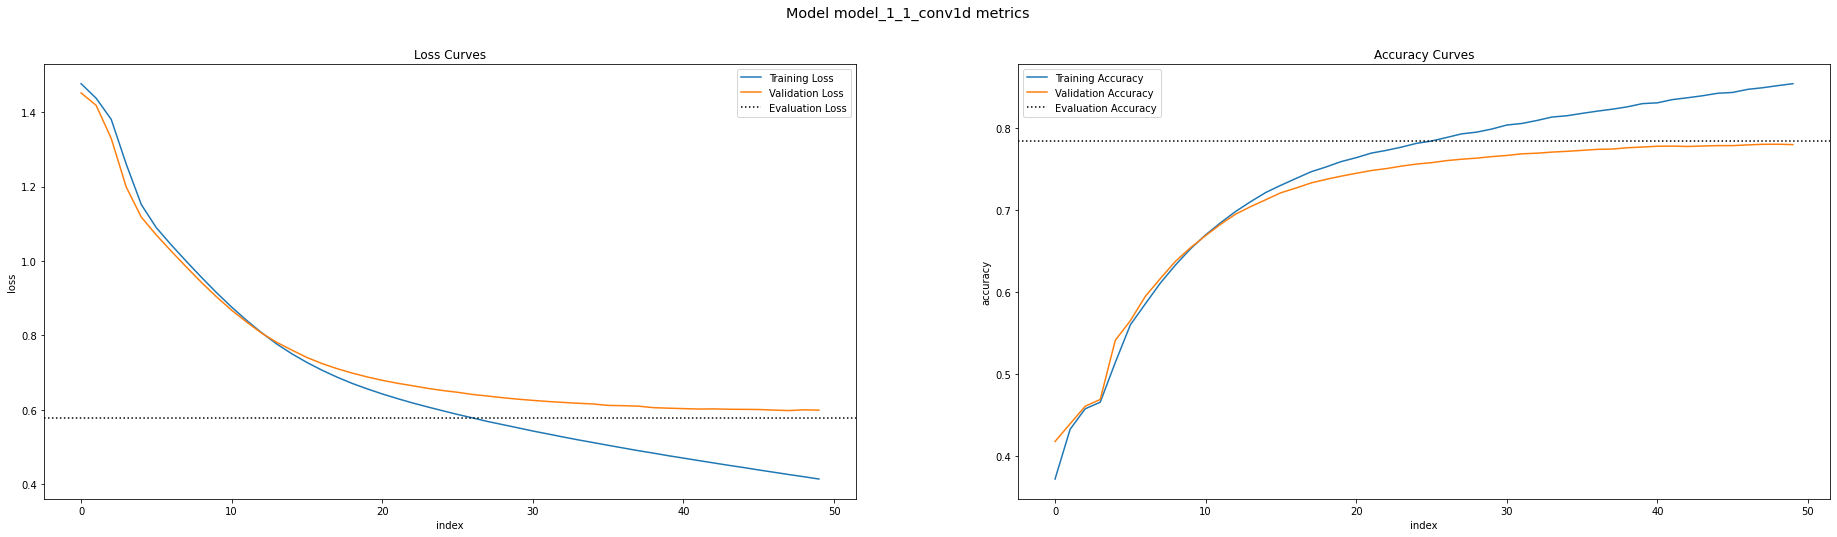

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1_2, eval_loss=model_1_2_eval[0], eval_acc=model_1_2_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_2_preds = tf.argmax(model_1_2.predict(test_txt), axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
# Create a classification report as dict
model_1_2_crp = classification_report(test_labels_encoded, model_1_2_preds, output_dict=True)

In [ ]:
model_1_2_crp_df = create_crp(model_1_2_crp, label_encoder.classes_, experiment_name='Model 1_2: Conv1D 32 filters')
model_1_2_crp_df

Model 1_2: Conv1D 32 filters                                  
                                 precision    recall  f1-score       support
0_background                      0.614823  0.610902  0.612856   3449.000000
1_conclusions                     0.656415  0.703405  0.679098   4582.000000
2_methods                         0.839741  0.898735  0.868237   9964.000000
3_objective                       0.712449  0.513047  0.596526   2376.000000
4_results                         0.861263  0.831420  0.846078   9841.000000
accuracy                          0.783993  0.783993  0.783993      0.783993
macro avg                         0.736938  0.711502  0.720559  30212.000000
weighted avg                      0.783261  0.783993  0.781811  30212.000000

#### Deeper NN

In [ ]:
# Create an embedding layer for model_1_1
embedding_1_3 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Create conv1d model with additional Dropout layer
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1_3(x)
x = Conv1D(filters=32, kernel_size=3, strides=1)(x)
x = Conv1D(filters=32, kernel_size=3, strides=1)(x)
x = Conv1D(filters=32, kernel_size=3, strides=1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1_3 = tf.keras.Model(inputs, outputs, name='model_1_1_conv1d')

In [ ]:
model_1_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_1_3.summary()

Model: "model_1_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 27, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 32)            12320     
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 32)            3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 32)            3104      
                                                  

In [ ]:
history_1_3 = model_1_3.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)
)

Epoch 1/50
942/942 [==============================] - 22s 23ms/step - loss: 1.4659 - accuracy: 0.3658 - val_loss: 1.4419 - val_accuracy: 0.4088
Epoch 2/50
942/942 [==============================] - 21s 23ms/step - loss: 1.4150 - accuracy: 0.4094 - val_loss: 1.3789 - val_accuracy: 0.4153
Epoch 3/50
942/942 [==============================] - 21s 23ms/step - loss: 1.2966 - accuracy: 0.4465 - val_loss: 1.1878 - val_accuracy: 0.5168
Epoch 4/50
942/942 [==============================] - 21s 22ms/step - loss: 1.0755 - accuracy: 0.5699 - val_loss: 0.9868 - val_accuracy: 0.6072
Epoch 5/50
942/942 [==============================] - 21s 22ms/step - loss: 0.9320 - accuracy: 0.6265 - val_loss: 0.8847 - val_accuracy: 0.6425
Epoch 6/50
942/942 [==============================] - 21s 22ms/step - loss: 0.8407 - accuracy: 0.6626 - val_loss: 0.8217 - val_accuracy: 0.6752
Epoch 7/50
942/942 [==============================] - 21s 22ms/step - loss: 0.7798 - accuracy: 0.6946 - val_loss: 0.7741 - val_accuracy:

In [ ]:
# Evaluate on test data
model_1_3_eval = model_1_3.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.9330 - accuracy: 0.7467


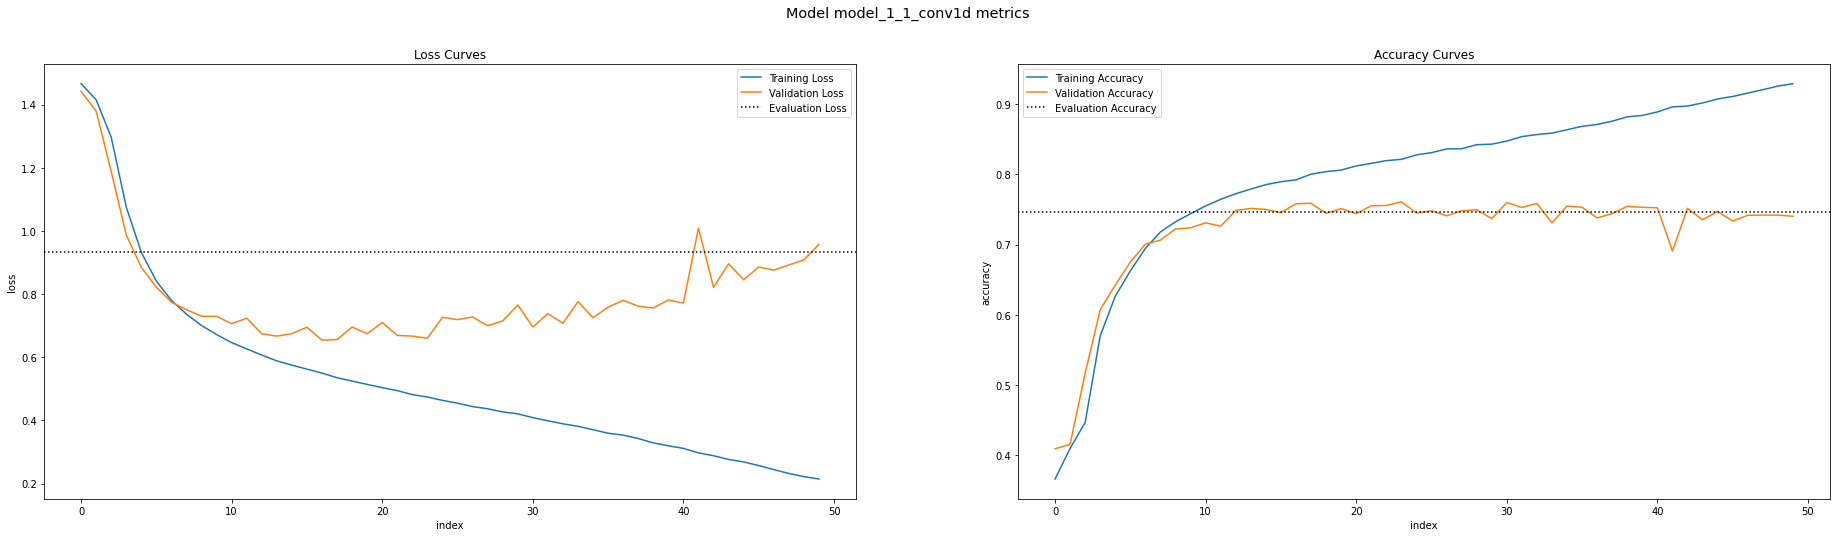

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1_3, eval_loss=model_1_3_eval[0], eval_acc=model_1_3_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_3_preds = tf.argmax(model_1_3.predict(test_txt), axis=1)

945/945 [==============================] - 3s 3ms/step


In [ ]:
# Create a classification report as dict
model_1_3_crp = classification_report(test_labels_encoded, model_1_3_preds, output_dict=True)

In [ ]:
model_1_3_crp_df = create_crp(model_1_3_crp, label_encoder.classes_, experiment_name='Model 1_3: Conv1D 32.filters kernel.3 x3 ')
model_1_3_crp_df

Model 1_3: Conv1D 32.filters kernel.3 x3                       \
                                              precision    recall  f1-score   
0_background                                   0.522638  0.615831  0.565420   
1_conclusions                                  0.679250  0.592973  0.633186   
2_methods                                      0.789782  0.892112  0.837834   
3_objective                                    0.605152  0.484428  0.538102   
4_results                                      0.853965  0.780205  0.815421   
accuracy                                       0.746690  0.746690  0.746690   
macro avg                                      0.690158  0.673110  0.677992   
weighted avg                                   0.748908  0.746690  0.744825   

                            
                   support  
0_background    3449.00000  
1_conclusions   4582.00000  
2_methods       9964.00000  
3_objective     2376.00000  
4_results       9841.00000  
accuracy           0.74669  
macro avg      30212.00000  
weighted avg   30212.00000

#### Even wider convolution

In [ ]:
# Create an embedding layer for model_1_1
embedding_1_4 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Create conv1d model with additional Dropout layer
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1_4(x)
x = Conv1D(filters=64, kernel_size=5, strides=1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(5, activation='sigmoid')(x)

model_1_4 = tf.keras.Model(inputs, outputs, name='model_1_4_conv1d')

In [ ]:
model_1_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_1_4.summary()

Model: "model_1_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 27, 128)           1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 23, 64)            41024     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 5)            

In [ ]:
history_1_4 = model_1_4.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)
)

Epoch 1/50
942/942 [==============================] - 20s 21ms/step - loss: 1.4770 - accuracy: 0.3632 - val_loss: 1.4555 - val_accuracy: 0.4218
Epoch 2/50
942/942 [==============================] - 20s 21ms/step - loss: 1.4434 - accuracy: 0.4429 - val_loss: 1.4245 - val_accuracy: 0.4494
Epoch 3/50
942/942 [==============================] - 20s 21ms/step - loss: 1.3847 - accuracy: 0.4624 - val_loss: 1.3362 - val_accuracy: 0.4646
Epoch 4/50
942/942 [==============================] - 20s 21ms/step - loss: 1.2824 - accuracy: 0.4696 - val_loss: 1.2352 - val_accuracy: 0.4722
Epoch 5/50
942/942 [==============================] - 20s 21ms/step - loss: 1.1905 - accuracy: 0.4987 - val_loss: 1.1534 - val_accuracy: 0.5306
Epoch 6/50
942/942 [==============================] - 20s 21ms/step - loss: 1.1213 - accuracy: 0.5487 - val_loss: 1.0948 - val_accuracy: 0.5567
Epoch 7/50
942/942 [==============================] - 20s 21ms/step - loss: 1.0664 - accuracy: 0.5783 - val_loss: 1.0424 - val_accuracy:

In [ ]:
# Evaluate on test data
model_1_4_eval = model_1_4.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.5745 - accuracy: 0.7864


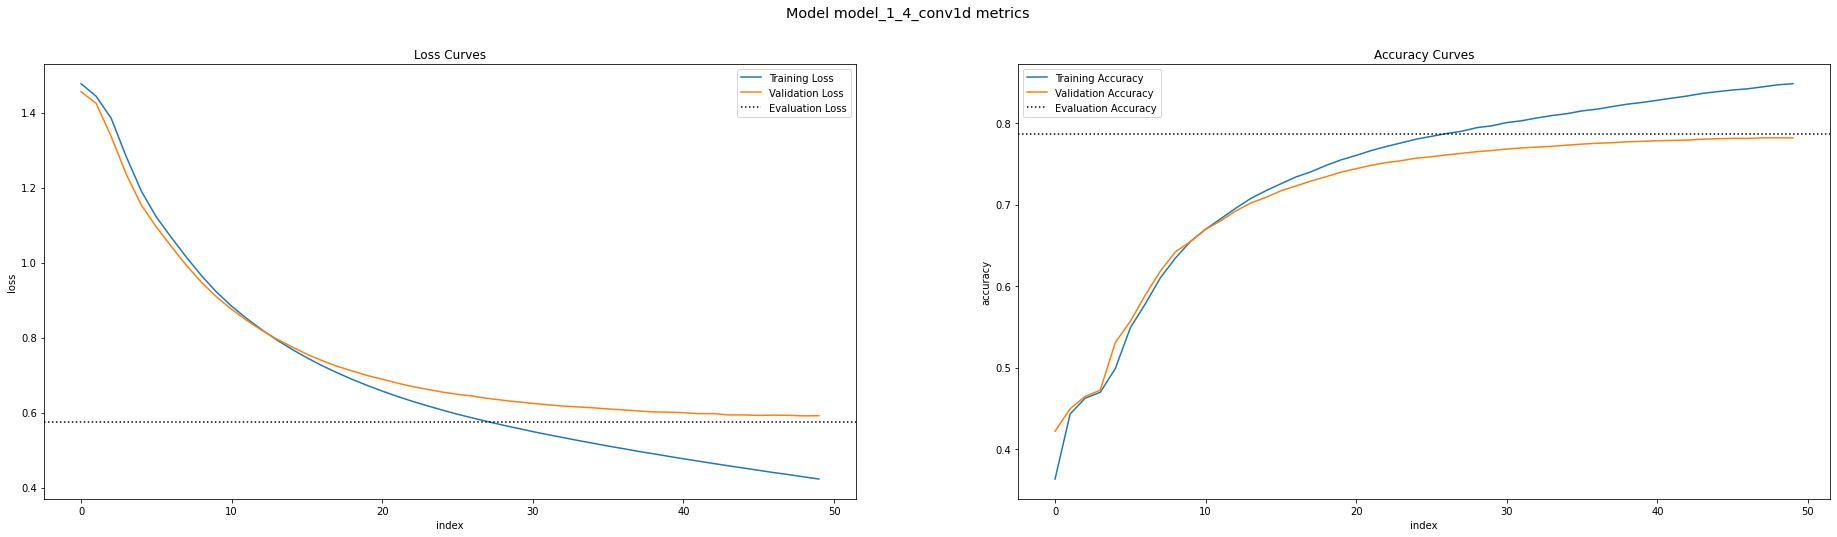

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1_4, eval_loss=model_1_4_eval[0], eval_acc=model_1_4_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_4_preds = tf.argmax(model_1_4.predict(test_txt), axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
# Create a classification report as dict
model_1_4_crp = classification_report(test_labels_encoded, model_1_4_preds, output_dict=True)

In [ ]:
model_1_4_crp_df = create_crp(model_1_4_crp, label_encoder.classes_, experiment_name='Model 1_4: Conv1D 64.filters kernel.5 ')
model_1_4_crp_df

Model 1_4: Conv1D 64.filters kernel.5                       \
                                           precision    recall  f1-score   
0_background                                0.574981  0.650333  0.610340   
1_conclusions                               0.694026  0.664339  0.678858   
2_methods                                   0.846306  0.899137  0.871922   
3_objective                                 0.729812  0.505892  0.597564   
4_results                                   0.857511  0.844528  0.850970   
accuracy                                    0.786409  0.786409  0.786409   
macro avg                                   0.740527  0.712846  0.721931   
weighted avg                                0.786725  0.786409  0.784378   

                             
                    support  
0_background    3449.000000  
1_conclusions   4582.000000  
2_methods       9964.000000  
3_objective     2376.000000  
4_results       9841.000000  
accuracy           0.786409  
macro avg      30212.000000  
weighted avg   30212.000000

#### And again even wider convolution:)

## Dalej!

In [ ]:
# Create fresh embedding layer for model_1_5
embedding_1_5 = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=27)

In [ ]:
# Build a model
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding_1_5(x)
x = Conv1D(128, kernel_size=5, strides=1)(x)
x = GlobalMaxPooling1D()(x)

outputs = Dense(5, activation='softmax')(x)

model_1_5 = tf.keras.Model(inputs, outputs, name='model_1_5_conv1d_f128')

In [ ]:
# Compile the model
model_1_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_1_5.summary()

Model: "model_1_5_conv1d_f128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 27, 128)           1280000   
                                                                 
 conv1d_7 (Conv1D)           (None, 23, 128)           82048     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 5)       

In [ ]:
# Fit the model
history_1_5 = model_1_5.fit(
    tf.convert_to_tensor(train_txt, dtype=tf.string),
    train_labels_onehot,
    epochs=50,
    validation_data=(tf.convert_to_tensor(val_txt, dtype=tf.string), val_labels_onehot)
)

Epoch 1/50
942/942 [==============================] - 21s 22ms/step - loss: 1.4733 - accuracy: 0.3736 - val_loss: 1.4544 - val_accuracy: 0.4178
Epoch 2/50
942/942 [==============================] - 20s 22ms/step - loss: 1.4438 - accuracy: 0.4290 - val_loss: 1.4292 - val_accuracy: 0.4348
Epoch 3/50
942/942 [==============================] - 21s 22ms/step - loss: 1.4030 - accuracy: 0.4407 - val_loss: 1.3674 - val_accuracy: 0.4485
Epoch 4/50
942/942 [==============================] - 21s 22ms/step - loss: 1.3114 - accuracy: 0.4580 - val_loss: 1.2462 - val_accuracy: 0.4668
Epoch 5/50
942/942 [==============================] - 20s 22ms/step - loss: 1.1880 - accuracy: 0.4972 - val_loss: 1.1431 - val_accuracy: 0.5286
Epoch 6/50
942/942 [==============================] - 21s 22ms/step - loss: 1.1108 - accuracy: 0.5522 - val_loss: 1.0835 - val_accuracy: 0.5648
Epoch 7/50
942/942 [==============================] - 20s 22ms/step - loss: 1.0538 - accuracy: 0.5905 - val_loss: 1.0297 - val_accuracy:

In [ ]:
# Evaluate on test data
model_1_5_eval = model_1_5.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 3s 3ms/step - loss: 0.5707 - accuracy: 0.7853


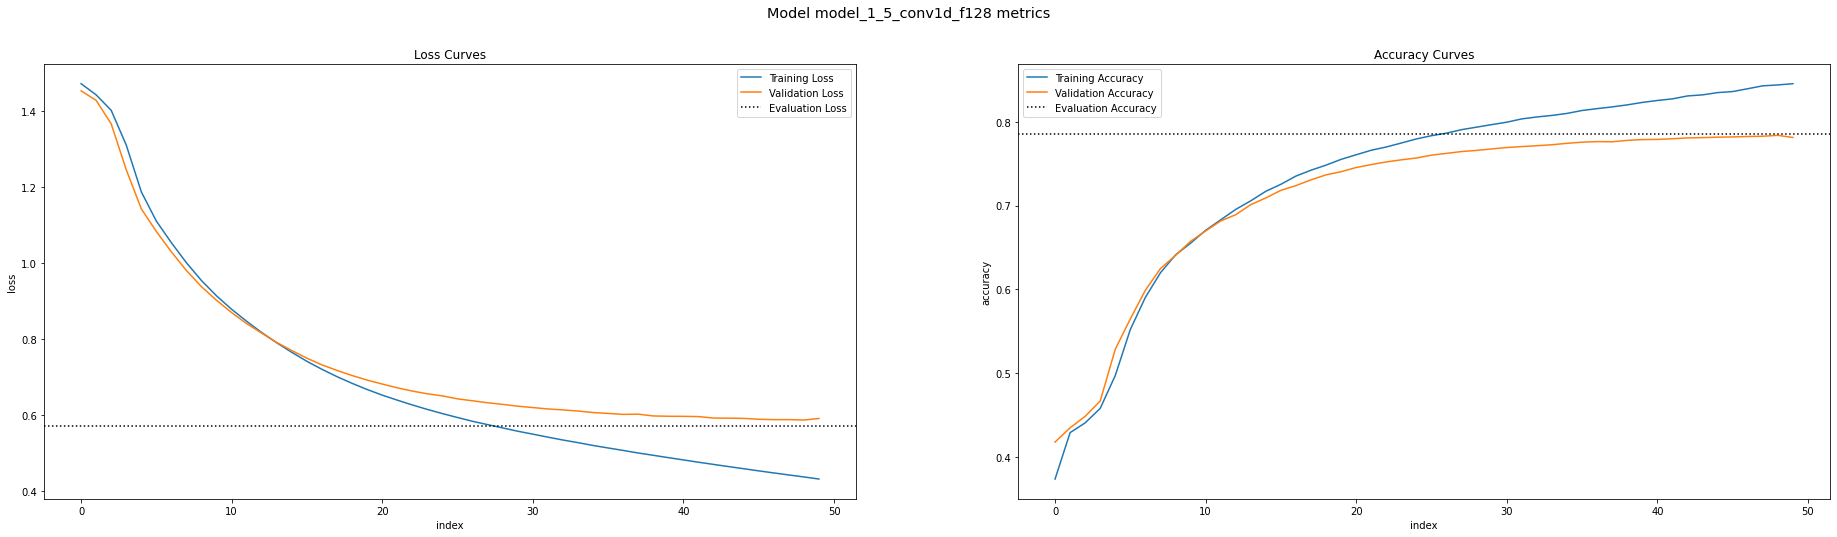

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_1_5, eval_loss=model_1_5_eval[0], eval_acc=model_1_5_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_1_5_preds = tf.argmax(model_1_5.predict(test_txt), axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
# Create a classification report as dict
model_1_5_crp = classification_report(test_labels_encoded, model_1_4_preds, output_dict=True)

In [ ]:
model_1_5_crp_df = create_crp(model_1_5_crp, label_encoder.classes_, experiment_name='Model 1_5: Conv1D 128.filters kernel.5 ')
model_1_5_crp_df

Model 1_5: Conv1D 128.filters kernel.5                       \
                                            precision    recall  f1-score   
0_background                                 0.574981  0.650333  0.610340   
1_conclusions                                0.694026  0.664339  0.678858   
2_methods                                    0.846306  0.899137  0.871922   
3_objective                                  0.729812  0.505892  0.597564   
4_results                                    0.857511  0.844528  0.850970   
accuracy                                     0.786409  0.786409  0.786409   
macro avg                                    0.740527  0.712846  0.721931   
weighted avg                                 0.786725  0.786409  0.784378   

                             
                    support  
0_background    3449.000000  
1_conclusions   4582.000000  
2_methods       9964.000000  
3_objective     2376.000000  
4_results       9841.000000  
accuracy           0.786409  
macro avg      30212.000000  
weighted avg   30212.000000

## Model 2: Universal Sentence Encoder based

In [ ]:
# Download TFHub USE
import tensorflow_hub as hub
USE_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False)

In [ ]:
USE_embedding(['Bitch, stop bitchin bitchy bitch. Bitch!']).shape

TensorShape([1, 512])

In [ ]:
# Create model 2 using functional API
inputs = Input(shape=[], dtype='string', )
x = USE_embedding(inputs)
outputs = Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

In [ ]:
# Compile the model
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)

In [ ]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=int(.1 * len(val_dataset))
)

Epoch 1/50
942/942 [==============================] - 15s 14ms/step - loss: 1.4830 - accuracy: 0.4024 - val_loss: 1.4298 - val_accuracy: 0.4789
Epoch 2/50
942/942 [==============================] - 13s 13ms/step - loss: 1.3993 - accuracy: 0.4939 - val_loss: 1.3820 - val_accuracy: 0.5054
Epoch 3/50
942/942 [==============================] - 13s 13ms/step - loss: 1.3559 - accuracy: 0.5119 - val_loss: 1.3424 - val_accuracy: 0.5147
Epoch 4/50
942/942 [==============================] - 13s 13ms/step - loss: 1.3185 - accuracy: 0.5168 - val_loss: 1.3074 - val_accuracy: 0.5191
Epoch 5/50
942/942 [==============================] - 14s 14ms/step - loss: 1.2854 - accuracy: 0.5207 - val_loss: 1.2764 - val_accuracy: 0.5241
Epoch 6/50
942/942 [==============================] - 12s 13ms/step - loss: 1.2560 - accuracy: 0.5267 - val_loss: 1.2486 - val_accuracy: 0.5316
Epoch 7/50
942/942 [==============================] - 13s 13ms/step - loss: 1.2297 - accuracy: 0.5336 - val_loss: 1.2238 - val_accuracy:

In [ ]:
sample = [x for x, y in train_dataset.take(1)]

In [ ]:
sample

[<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
        b'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
        b'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
        b'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
        b"the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-

In [ ]:
# Evaluate on test data
model_2_eval = model_2.evaluate( tf.convert_to_tensor(test_txt, dtype=tf.string), test_labels_onehot)

945/945 [==============================] - 9s 9ms/step - loss: 0.9013 - accuracy: 0.6682


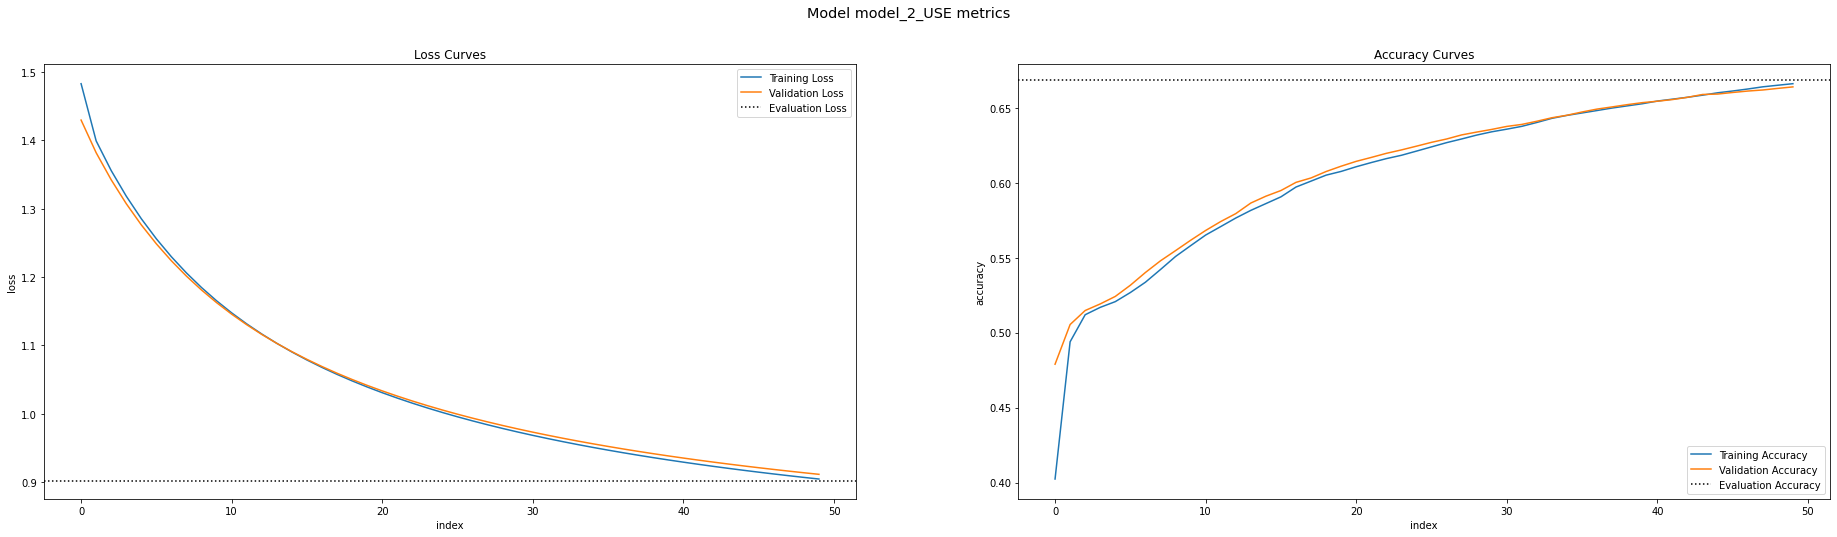

In [ ]:
# Plot curves and evaluation metrics
plot_curves_eval(history_2, eval_loss=model_2_eval[0], eval_acc=model_2_eval[1])

In [ ]:
# predict the labels and transform them into encoded-like label array
model_2_preds = tf.argmax(model_2.predict(test_txt), axis=1)

945/945 [==============================] - 8s 8ms/step


In [ ]:
# Create a classification report as dict
model_2_crp = classification_report(test_labels_encoded, model_2_preds, output_dict=True)

In [ ]:
model_2_crp_df = create_crp(model_2_crp, label_encoder.classes_, experiment_name='Model 2: plain USE ')
model_2_crp_df

Model 2: plain USE                                   
                        precision    recall  f1-score       support
0_background             0.591649  0.316324  0.412243   3449.000000
1_conclusions            0.540812  0.540812  0.540812   4582.000000
2_methods                0.664704  0.849558  0.745848   9964.000000
3_objective              0.716400  0.244529  0.364606   2376.000000
4_results                0.739648  0.769637  0.754345   9841.000000
accuracy                 0.668244  0.668244  0.668244      0.668244
macro avg                0.650642  0.544172  0.563571  30212.000000
weighted avg             0.666051  0.668244  0.649453  30212.000000